# Import modules

In [1]:
import datetime
import itertools
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from tx_fast_hydrology.muskingum import Muskingum, ModelCollection, Connection
from tx_fast_hydrology.simulation import AsyncSimulation
from tx_fast_hydrology.da import KalmanFilter

# Load model collection

In [2]:
# Define model file input path
input_path = '../data/travis-county-lo-res-model-partitioned.json'
# Load model collection from file
model_collection = ModelCollection.from_file(input_path)

# Create model inputs

### Load NWM forcings

In [ ]:
# Define path for NWM forcings
forcing_path = '../data/20220822_event'
# Required NWM variables
nwm_vars = ['qBucket', 'qSfcLatRunoff', 'streamflow']
# Date range to load
date_list = pd.date_range('20220822', '20220824', freq='h', tz='utc')[:-1]

# Loop through HDF5 files and load forcings into memory
streamflows = []
runoffs = []
buckets = []
for date in date_list:
    date_str = date.strftime('%Y%m%d%H')
    streamflow = pd.read_hdf(f'{forcing_path}/{date_str}.h5', key='no_data_assimilation__streamflow')
    runoff = pd.read_hdf(f'{forcing_path}/{date_str}.h5', key='no_data_assimilation__qSfcLatRunoff')
    bucket = pd.read_hdf(f'{forcing_path}/{date_str}.h5', key='no_data_assimilation__qBucket')
    streamflows.append(streamflow)
    runoffs.append(runoff)
    buckets.append(bucket)
# Concatenate all forcings into single dataframe
streamflow = pd.concat(streamflows)
runoff = pd.concat(runoffs)
bucket = pd.concat(buckets)
# Lateral inflow at each reach is equal to runoff plus bucket recharge
forcing = runoff + bucket

# Ensure no duplicate entries
forcing = forcing.groupby(level=0).mean()
streamflow = streamflow.groupby(level=0).mean()

# Format column types
forcing.columns = forcing.columns.astype(str)
streamflow.columns = forcing.columns.astype(str)

### Create inputs to model based on forcings

In [4]:
# Create input table with lateral overflow into each modeled reach
input_columns = list(itertools.chain.from_iterable([model.reach_ids for model 
                                                    in model_collection.models.values()]))
input_index = forcing.index.copy()
inputs = pd.DataFrame(0., index=input_index, columns=input_columns)

# Fill input table with forcings for each reach
for col in inputs.columns:
    if col in forcing.columns:
        inputs[col] = forcing[col]

# Add inflow to upstream boundary reaches
upstream_inputs = {
    '5779305' : '5781161',
    '5785187' : '5785899',
    '5786029' : '5785351'
}
for downstream_reach, upstream_reach in upstream_inputs.items():
    inputs[downstream_reach] += streamflow[upstream_reach]

In [5]:
# Resample forcing input table to frequency of model timestep
dt = model_collection.timedelta.seconds
inputs = inputs.resample(f'{dt}s').mean()
inputs = inputs.interpolate().bfill().ffill()
assert not inputs.isnull().any().any()

# Gather gage measurements for event period

In [ ]:
# Load table of mappings from USGS Gage IDs to NWM COMIDs
usgs_to_comid = pd.read_csv('../data/usgs_to_comid.csv', index_col=0)
usgs_to_comid['gage_id'] = usgs_to_comid['gage_id'].astype(str)
usgs_to_comid['comid'] = usgs_to_comid['comid'].astype(str)
# Filter 
usgs_to_comid = usgs_to_comid[usgs_to_comid['comid'].isin(input_columns)]
usgs_to_comid = pd.Series(usgs_to_comid['comid'].values, index=usgs_to_comid['gage_id'].values)

# Load table of USGS gage measurements
measurements = pd.read_hdf('../data/gages.h5', key='usgs')
measurements.columns = measurements.columns.astype(int).astype(str)
# Filter measurements to those with associated COMIDs
measurements = measurements[usgs_to_comid.index]
measurements.columns = measurements.columns.map(usgs_to_comid)
measurements = measurements.loc[forcing.index[0]:forcing.index[-1]]
measurements = measurements.dropna(axis=1)
measurements = measurements.loc[:, ~(measurements == 0.).all(axis=0).values]
measurements = measurements.loc[:, ~measurements.columns.duplicated()].copy()
# measurements = measurements.resample(f'{dt}s').mean().interpolate().ffill().bfill()
measurements = measurements.resample(f'1h').mean().interpolate().ffill().bfill() ### changed

# Set up Kalman Filter

In [ ]:
# Set up Kalman Filtering
for model in model_collection.models.values():
    # Find subset of gages for each sub-model
    model_sites = [reach_id for reach_id in model.reach_ids 
                    if reach_id in measurements.columns]
    if model_sites:
        # Get subset of measurements for sub-model
        basin_measurements = measurements[model_sites]
        # Process noise covariance matrix
        Q_cov = 1. * np.eye(model.n)
        # Measurement noise covariance matrix
        R_cov = 1. * np.eye(basin_measurements.shape[1])
        # Initial estimate of error covariance matrix
        P_t_init = Q_cov.copy()
        # Create Kalman Filter
        kf = KalmanFilter(model, basin_measurements, Q_cov, R_cov, P_t_init)
        # Bind Kalman Filter to model
        # model.bind_callback(kf, key='kf') 
        if not hasattr(model, 'callbacks'): ### changed
            model.callbacks = {}
        model.callbacks['kf'] = kf

# Prepare and simulate model

### Prepare model for simulation

In [ ]:
# Add downstream boundaries to model
for model in model_collection.models.values():
    outlet = model.startnodes[model.startnodes == model.endnodes].item()
    model.set_transmissive_boundary(outlet)

# Set starting time of each model to just before start of forcings
timedelta = pd.to_timedelta(dt, unit='s')
for model_name, model in model_collection.models.items():
    model.datetime = inputs.index[0] - pd.to_timedelta('1h') ### changed

# Set up simulation
simulation = AsyncSimulation(model_collection, inputs)

### Simulate model

In [9]:
# # Simulate models
# outputs_da = await simulation.simulate()
# # Collect outputs into a single table
# outputs_da = pd.concat([series for series in outputs_da.values()], axis=1)

### changed for forecasting, needs to be cleaned up.

In [10]:
def load_nwm_data(forcing_path, date):
    date_str = date.strftime('%Y%m%d%H')
    streamflow = pd.read_hdf(f'{forcing_path}/{date_str}.h5', key='short_range__streamflow')
    runoff = pd.read_hdf(f'{forcing_path}/{date_str}.h5', key='short_range__qSfcLatRunoff')
    bucket = pd.read_hdf(f'{forcing_path}/{date_str}.h5', key='short_range__qBucket')


    forcing = runoff + bucket
    return streamflow, forcing

In [11]:
all_outputs_da = {}
for date in date_list:
    date_str = date.strftime('%Y%m%d%H')
    model_collection.load_states()
    
    streamflow, forcing = load_nwm_data(forcing_path, date)
    forcing.columns = forcing.columns.astype(str)
    streamflow.columns = forcing.columns.astype(str)
    inputs = forcing

    input_columns = list(itertools.chain.from_iterable([model.reach_ids for model 
                                                    in model_collection.models.values()]))
    input_index = forcing.index.copy()
    inputs = pd.DataFrame(0., index=input_index, columns=input_columns)

    # Fill input table with forcings for each reach
    for col in inputs.columns:
        if col in forcing.columns:
            inputs[col] = forcing[col]

    # Add inflow to upstream boundary reaches
    upstream_inputs = {
        '5779305' : '5781161',
        '5785187' : '5785899',
        '5786029' : '5785351'
    }
    for downstream_reach, upstream_reach in upstream_inputs.items():
        inputs[downstream_reach] += streamflow[upstream_reach]

    inputs.columns = inputs.columns.astype(str)
    dt = model_collection.timedelta.seconds
    inputs = inputs.resample(f'{dt}s').mean()
    inputs = inputs.interpolate().bfill().ffill()

    if hasattr(model, 'callbacks') and 'kf' in model.callbacks:
        measurement_timestep = date
        measurements_columns = model.callbacks['kf'].measurements.columns
        model.callbacks['kf'].measurements = basin_measurements.loc[[measurement_timestep], measurements_columns]
    
    for model in model_collection.models.values():
        outlet = model.startnodes[model.startnodes == model.endnodes].item()
        model.set_transmissive_boundary(outlet)

    timedelta = pd.to_timedelta(dt, unit='s')
    for model_name, model in model_collection.models.items():
        model.datetime = inputs.index[0] - pd.to_timedelta('1h')

    simulation = AsyncSimulation(model_collection, inputs)
    outputs = await simulation.simulate()
    all_outputs_da[date_str] = pd.concat([series for series in outputs.values()], axis=1)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [54]:
site = '5671187'

site_output_da = {}
for date in date_list:
    date_str = date.strftime('%Y%m%d%H')
    site_output_da[date] = all_outputs_da[date_str][site]

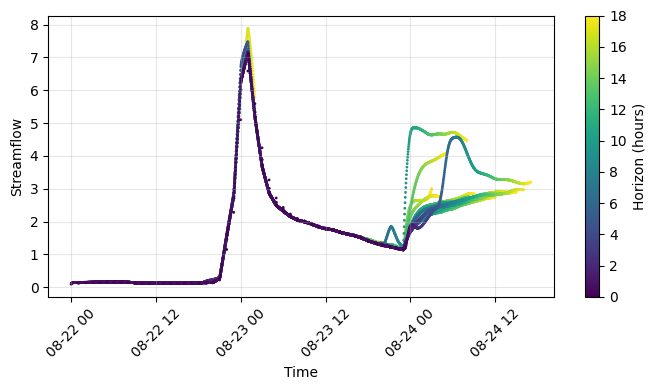

In [55]:
fig, ax = plt.subplots(figsize=(7, 4))

max_horizon = 0
for forecast_time, forecast_series in site_output_da.items():
    horizons = [(target_time - forecast_time).total_seconds() / 3600 
               for target_time in forecast_series.index]
    max_horizon = max(max_horizon, max(horizons))

all_target_times = []
all_values = []
all_horizons = []

for forecast_time, forecast_series in list(site_output_da.items()):
    horizons = [(target_time - forecast_time).total_seconds() / 3600 
               for target_time in forecast_series.index]
    
    all_target_times.extend(forecast_series.index)
    all_values.extend(forecast_series.values)
    all_horizons.extend(horizons)

scatter = ax.scatter(all_target_times, all_values, 
                    c=all_horizons, cmap='viridis', s=1, alpha=1,
                    vmin=0, vmax=max_horizon)

plt.colorbar(scatter, ax=ax, label='Horizon (hours)')
ax.set_xlabel('Time')
ax.set_ylabel('Streamflow')
ax.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Time-lagged ensemble mean

In [56]:
da_spreads = {}
da_spread = pd.concat((value for value in site_output_da.values()), axis=1)
da_spreads = da_spread

In [57]:
def mean_first_12_hours(row):
    valid_values = row.dropna()[-19:-12]
    return valid_values.mean()

In [58]:
timelagged_da = da_spreads.apply(mean_first_12_hours, axis=1)

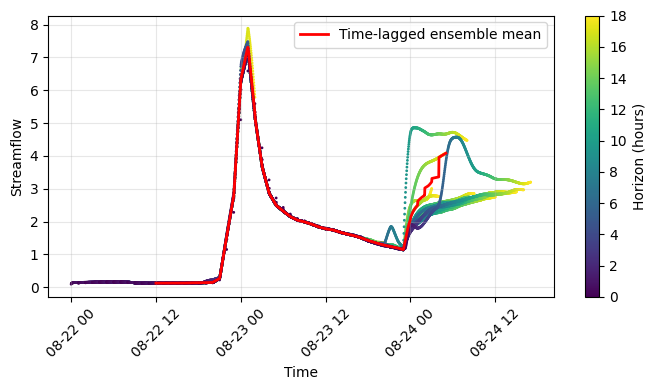

In [62]:
fig, ax = plt.subplots(figsize=(7, 4))

max_horizon = 0
for forecast_time, forecast_series in site_output_da.items():
    horizons = [(target_time - forecast_time).total_seconds() / 3600 
               for target_time in forecast_series.index]
    max_horizon = max(max_horizon, max(horizons))

all_target_times = []
all_values = []
all_horizons = []

for forecast_time, forecast_series in list(site_output_da.items()):
    horizons = [(target_time - forecast_time).total_seconds() / 3600 
               for target_time in forecast_series.index]
    
    all_target_times.extend(forecast_series.index)
    all_values.extend(forecast_series.values)
    all_horizons.extend(horizons)

scatter = ax.scatter(all_target_times, all_values, 
                    c=all_horizons, cmap='viridis', s=1, alpha=1,
                    vmin=0, vmax=max_horizon)
plt.plot(timelagged_da.index, timelagged_da.values, color='red', linewidth=2, label='Time-lagged ensemble mean')
plt.colorbar(scatter, ax=ax, label='Horizon (hours)')
ax.set_xlabel('Time')
ax.set_ylabel('Streamflow')
ax.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend()
plt.show()